In [115]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LogisticRegression
import numpy as np

# Load additional datasets where necessary within functions
def load_data(file_name):
    csv_path = os.path.join(os.getcwd(), "Cleaned_Dataset", file_name)
    return pd.read_csv(csv_path, low_memory=False)

# Function: Driver & Constructor Performance
def driver_constructor_performance(df):
    """Analyze driver and constructor performance based on wins, podiums, and points."""
    # Calculate driver metrics
    wins = df[df['position'] == 1].groupby('driverId').size()
    podiums = df[df['position'].isin([1, 2, 3])].groupby('driverId').size()
    total_points = df.groupby('driverId')['points'].sum()
    total_races = df.groupby('driverId').size()
    win_ratio = (wins / total_races).fillna(0)

    # Calculate constructor metrics
    constructor_wins = df[df['position'] == 1].groupby('constructorId').size()
    constructor_podiums = df[df['position'].isin([1, 2, 3])].groupby('constructorId').size()

    # Output top performers
    print("Top 5 Drivers by Win Ratio:\n", win_ratio.sort_values(ascending=False).head(5))
    print("Top 5 Constructors by Wins:\n", constructor_wins.sort_values(ascending=False).head(5))

# Function: Qualifying vs. Race Performance
def qualifying_vs_race_performance(df):
    """Compare qualifying grid positions to final race positions."""
    df['position_gain'] = df['grid'] - df['position']  # Positive = improved position
    avg_gain = df.groupby('driverId')['position_gain'].mean().sort_values(ascending=False)
    print("Top 5 Drivers by Average Position Gain:\n", avg_gain.head(5))

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='grid', y='position', hue='points', size='points', data=df)
    plt.title("Qualifying Grid vs. Race Position")
    plt.xlabel("Grid Position")
    plt.ylabel("Final Position")
    plt.show()

# Function: Pit Stop Strategies Analysis
def analyze_pit_stop_strategies(df):
    """Analyze pit stop strategies using pit stop data."""
    pit_df = load_data("master_pit_stops.csv")
    pit_counts = pit_df.groupby(['raceId', 'driverId']).size().reset_index(name='pit_stops')
    merged_df = df.merge(pit_counts, on=['raceId', 'driverId'], how='left').fillna(0)
    
    # Correlation between pit stops and position
    correlation = merged_df['pit_stops'].corr(merged_df['position'])
    print(f"Correlation between Pit Stops and Finishing Position: {correlation:.2f}")

    # Average pit stops by finishing position
    avg_pits = merged_df.groupby('position')['pit_stops'].mean()
    avg_pits.plot(kind='bar', title="Average Pit Stops by Finishing Position")
    plt.xlabel("Finishing Position")
    plt.ylabel("Average Pit Stops")
    plt.show()

# Function: Head-to-Head Driver Analysis
def head_to_head_analysis(df):
    """Compare head-to-head performance between drivers in the same race."""
    # Calculate average positions for each driver across all races
    avg_positions = df.groupby(['driverId', 'raceId'])['position'].mean().reset_index()
    
    # Create a pivot table for driver comparisons
    driver_matrix = avg_positions.pivot(index='raceId', columns='driverId', values='position')
    
    # Create correlation matrix
    corr_matrix = driver_matrix.corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title("Driver Head-to-Head Performance Correlation")
    plt.xlabel("Driver ID")
    plt.ylabel("Driver ID")
    plt.show()
    
    # Print top 5 most closely matched driver pairs
    correlations = corr_matrix.unstack()
    correlations = correlations[correlations != 1.0]  # Remove self-correlations
    print("\nTop 5 Most Closely Matched Driver Pairs:")
    print(correlations.sort_values(ascending=False).head(5))
    # Function: Hypothetical Driver Swaps Simulation
def hypothetical_driver_swap(df, driver1, driver2):
    """Simulate swapping two drivers and estimate impact."""
    # Ensure year and constructorId are integers
    df['year'] = df['year'].astype(int)
    df['constructorId'] = df['constructorId'].astype(int)

    # Convert driver names to IDs if necessary
    if isinstance(driver1, str):
        driver1_id = df[df['driverRef'].str.lower() == driver1.lower()]['driverId'].unique()
        driver2_id = df[df['driverRef'].str.lower() == driver2.lower()]['driverId'].unique()

        if len(driver1_id) == 0 or len(driver2_id) == 0:
            print(f"Error: One or both drivers ({driver1}, {driver2}) not found in dataset")
            return
        driver1, driver2 = driver1_id[0], driver2_id[0]

    # Check if drivers exist in the dataset
    if not (driver1 in df['driverId'].unique() and driver2 in df['driverId'].unique()):
        print(f"Error: One or both drivers (ID: {driver1}, {driver2}) not found in dataset")
        return

    # Get common seasons for both drivers
    driver1_seasons = set(df[df['driverId'] == driver1]['year'])
    driver2_seasons = set(df[df['driverId'] == driver2]['year'])
    common_seasons = list(driver1_seasons.intersection(driver2_seasons))
    
    if not common_seasons:
        print("Error: No overlapping seasons found for these drivers")
        return
        
    # Filter data for common seasons
    mask = df['year'].isin(common_seasons)
    driver1_data = df[mask & (df['driverId'] == driver1)].copy()
    driver2_data = df[mask & (df['driverId'] == driver2)].copy()
    
    # Get original stats for comparison
    orig_driver1_avg = driver1_data['position'].mean()
    orig_driver2_avg = driver2_data['position'].mean()
    
    # Calculate team performance factors for each season from the subset
    team_perf = df[mask].groupby(['year', 'constructorId'])['position'].mean().reset_index()
    
    # Simulate swapped positions
    sim_driver1 = []
    sim_driver2 = []
    
    for year in common_seasons:
        d1_year = driver1_data[driver1_data['year'] == year]
        d2_year = driver2_data[driver2_data['year'] == year]
        
        try:
            if not d1_year.empty and not d2_year.empty:
                # Cast constructorId to int for consistency
                d1_const = int(d1_year['constructorId'].iloc[0])
                d2_const = int(d2_year['constructorId'].iloc[0])
                
                t1 = team_perf[(team_perf['year'] == year) & (team_perf['constructorId'] == d1_const)]
                t2 = team_perf[(team_perf['year'] == year) & (team_perf['constructorId'] == d2_const)]
                
                if t1.empty or t2.empty:
                    print(f"Warning: No team performance data for year {year} "
                          f"for constructor {d1_const if t1.empty else d2_const}")
                    continue
                  
                d1_team_perf = t1.iloc[0]['position']
                d2_team_perf = t2.iloc[0]['position']
                
                if d1_team_perf != 0 and d2_team_perf != 0:
                    # Adjust positions based on team performance
                    sim_driver1.extend(d1_year['position'].values * (d2_team_perf / d1_team_perf))
                    sim_driver2.extend(d2_year['position'].values * (d1_team_perf / d2_team_perf))
        except Exception as e:
            print(f"Warning: Error processing year {year}: {str(e)}")
            continue
    
    sim_driver1_avg = np.mean(sim_driver1) if sim_driver1 else float('nan')
    sim_driver2_avg = np.mean(sim_driver2) if sim_driver2 else float('nan')
    
    print(f"\nOriginal Average Positions:")
    print(f"Driver {driver1}: {orig_driver1_avg:.2f}")
    print(f"Driver {driver2}: {orig_driver2_avg:.2f}")
    print(f"\nSimulated Average Positions after Swap:")
    print(f"Driver {driver1}: {sim_driver1_avg:.2f}")
    print(f"Driver {driver2}: {sim_driver2_avg:.2f}")
    
# Function: Driver Movements & Team Network Graph
def driver_team_network(df):
    """Build and visualize a network of driver movements between teams."""
    G = nx.DiGraph()
    driver_history = df.groupby('driverId').apply(lambda x: x[['constructorId', 'year']].sort_values('year'))
    
    for driver, history in driver_history.groupby('driverId'):
        teams = history['constructorId'].values
        years = history['year'].values
        for i in range(len(teams) - 1):
            G.add_edge(teams[i], teams[i + 1], driver=driver, year=years[i])
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, arrows=True)
    plt.title("Driver-Team Transition Network")
    plt.show()

# Function: Team Performance Comparison
def team_performance_comparison(df):
    """Compare team performance across circuits and against different opponents."""
    # Calculate overall team success rate (podium finishes)
    team_success = df[df['position'] <= 3].groupby('constructorId').size() / df.groupby('constructorId').size()
    
    # Calculate circuit-specific team success rates
    circuit_team_success = df[df['position'] <= 3].groupby(['circuitId', 'constructorId']).size() / \
                          df.groupby(['circuitId', 'constructorId']).size()
    circuit_team_success = circuit_team_success.unstack().fillna(0)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot 1: Overall success rates
    team_success.sort_values(ascending=False).head(10).plot(kind='bar', ax=ax1)
    ax1.set_title("Top 10 Teams by Overall Podium Success Rate")
    ax1.set_xlabel("Constructor ID")
    ax1.set_ylabel("Podium Success Rate")
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Circuit-specific success rates heatmap
    top_teams = team_success.sort_values(ascending=False).head(10).index
    top_circuits = df.groupby('circuitId').size().sort_values(ascending=False).head(10).index
    subset_heatmap = circuit_team_success.loc[top_circuits, top_teams]
    
    sns.heatmap(subset_heatmap, cmap='YlOrRd', ax=ax2)
    ax2.set_title("Team Success Rates by Circuit (Top 10 Teams & Circuits)")
    ax2.set_xlabel("Constructor ID")
    ax2.set_ylabel("Circuit ID")
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical results
    print("\nOverall Top 5 Teams by Success Rate:")
    print(team_success.sort_values(ascending=False).head(5))
    
    print("\nCircuit-Specific Success Rates (Sample):")
    print(circuit_team_success.mean().sort_values(ascending=False).head(5))

# Function: Driver Consistency Analysis
def driver_consistency(df):
    """Measure driver consistency and performance levels."""
    # Calculate basic consistency metrics
    consistency = df.groupby('driverId').agg({
        'position': ['std', 'mean', 'count']
    }).reset_index()
    consistency.columns = ['driverId', 'position_std', 'avg_position', 'races']
    
    # Filter drivers with minimum races for meaningful analysis
    min_races = 10
    consistency = consistency[consistency['races'] >= min_races]
    
    # Calculate percentage of top 10 finishes
    top_10_finishes = df[df['position'] <= 10].groupby('driverId').size()
    total_races = df.groupby('driverId').size()
    top_10_ratio = (top_10_finishes / total_races * 100).round(2)
    
    # Combine metrics
    consistency['top_10_ratio'] = consistency['driverId'].map(top_10_ratio)
    
    # Sort and display results
    print("Most Consistent Top Performers:")
    top_performers = consistency[
        (consistency['avg_position'] < 10) & 
        (consistency['position_std'] < consistency['position_std'].median())
    ].sort_values('position_std')
    print(top_performers[['driverId', 'position_std', 'avg_position', 'top_10_ratio']].head())
    
    print("\nMost Inconsistent Drivers:")
    inconsistent = consistency.nlargest(5, 'position_std')
    print(inconsistent[['driverId', 'position_std', 'avg_position', 'top_10_ratio']])

# Function: Lap Time Efficiency Comparison
def lap_time_efficiency(df):
    """Compare lap times across circuits and analyze team efficiency."""
    # Load lap times data
    lap_df = load_data("master_lap_times.csv")
    
    # Merge with main dataset to get constructor information
    lap_df = lap_df.merge(df[['raceId', 'driverId', 'constructorId']], on=['raceId', 'driverId'])
    
    # Calculate average lap times by driver and circuit
    avg_laps = lap_df.groupby(['circuitId', 'driverId', 'constructorId'])['milliseconds'].mean().reset_index()
    
    # Calculate fastest lap for each circuit
    fastest_laps = lap_df.groupby('circuitId')['milliseconds'].min().reset_index()
    
    # Calculate efficiency metrics
    efficiency = avg_laps.merge(fastest_laps, on='circuitId', suffixes=('_avg', '_fast'))
    efficiency['efficiency_ratio'] = efficiency['milliseconds_fast'] / efficiency['milliseconds_avg']
    
    # Team efficiency analysis
    team_efficiency = efficiency.groupby('constructorId')['efficiency_ratio'].mean().sort_values(ascending=False)
    
    # Circuit-specific team performance
    team_circuit_performance = efficiency.pivot_table(
        values='efficiency_ratio',
        index='constructorId',
        columns='circuitId',
        aggfunc='mean'
    ).fillna(0)
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    team_efficiency.head(10).plot(kind='bar')
    plt.title('Top 10 Teams by Lap Time Efficiency')
    plt.xlabel('Constructor ID')
    plt.ylabel('Efficiency Ratio')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(team_circuit_performance.head(5), cmap='YlOrRd')
    plt.title('Top 5 Teams Performance by Circuit')
    plt.xlabel('Circuit ID')
    plt.ylabel('Constructor ID')
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical results
    print("\nTop 5 Teams by Overall Efficiency:")
    print(team_efficiency.head())
    
    print("\nTop 5 Drivers by Lap Time Efficiency:")
    driver_efficiency = efficiency.groupby('driverId')['efficiency_ratio'].mean().sort_values(ascending=False)
    print(driver_efficiency.head())

# Function: Best Team Lineup Selection
def best_team_lineup(df, recent_years=3):
    """
    Select optimal driver lineup based on multiple performance metrics.
    
    Args:
        df: DataFrame containing race results
        recent_years: Number of recent years to consider (default=3)
    """
    # Filter for recent years
    current_year = df['year'].max()
    recent_df = df[df['year'] >= current_year - recent_years]
    
    # Calculate various performance metrics
    driver_stats = pd.DataFrame()
    
    # Points per race
    points_per_race = recent_df.groupby('driverId').agg({
        'points': ['sum', 'mean'],
        'position': ['mean', 'std'],
        'raceId': 'count'
    }).round(2)
    
    points_per_race.columns = ['total_points', 'avg_points', 'avg_position', 'position_std', 'races']
    driver_stats = points_per_race.reset_index()
    
    # Calculate podium and win ratios
    podiums = recent_df[recent_df['position'] <= 3].groupby('driverId').size()
    wins = recent_df[recent_df['position'] == 1].groupby('driverId').size()
    
    driver_stats['podium_ratio'] = (driver_stats['driverId'].map(podiums) / driver_stats['races']).fillna(0).round(3)
    driver_stats['win_ratio'] = (driver_stats['driverId'].map(wins) / driver_stats['races']).fillna(0).round(3)
    
    # Filter drivers with minimum races
    min_races = 10
    driver_stats = driver_stats[driver_stats['races'] >= min_races]
    
    # Calculate composite score (weighted average of normalized metrics)
    for col in ['avg_points', 'podium_ratio', 'win_ratio']:
        driver_stats[f'{col}_norm'] = (driver_stats[col] - driver_stats[col].min()) / \
                                     (driver_stats[col].max() - driver_stats[col].min())
    
    driver_stats['consistency_score'] = 1 - (driver_stats['position_std'] / driver_stats['position_std'].max())
    
    # Calculate final score (weighted average)
    weights = {
        'avg_points_norm': 0.3,
        'podium_ratio_norm': 0.25,
        'win_ratio_norm': 0.25,
        'consistency_score': 0.2
    }
    
    driver_stats['final_score'] = sum(driver_stats[metric] * weight 
                                    for metric, weight in weights.items())
    
    # Sort by final score and get top drivers
    best_drivers = driver_stats.nlargest(5, 'final_score')
    
    print(f"\nBest Team Lineup (Based on last {recent_years} years):")
    print("\nTop 5 Drivers by Overall Performance:")
    print(best_drivers[['driverId', 'avg_points', 'podium_ratio', 'win_ratio', 
                       'consistency_score', 'final_score']].to_string(index=False))
    
    # Recommend optimal pair
    print("\nRecommended Driver Pairing:")
    top_pair = best_drivers.iloc[:2]
    print(f"Driver 1 ID: {top_pair.iloc[0]['driverId']} (Score: {top_pair.iloc[0]['final_score']:.3f})")
    print(f"Driver 2 ID: {top_pair.iloc[1]['driverId']} (Score: {top_pair.iloc[1]['final_score']:.3f})")

# Function: Season Predictions for 2025
def predictions_2025(df):
    """Predict 2025 champions based on recent trends and weighted performance metrics."""
    # Get recent data with more weight on recent years
    current_year = df['year'].max()
    recent_df = df[df['year'] >= 2020].copy()
    
    # Add year weights (more recent years have higher weight)
    recent_df['year_weight'] = (recent_df['year'] - 2019) / (current_year - 2019)
    
    # Calculate weighted points
    recent_df['weighted_points'] = recent_df['points'] * recent_df['year_weight']
    
    # Driver predictions
    driver_metrics = recent_df.groupby('driverId').agg({
        'weighted_points': 'sum',
        'points': 'sum',
        'position': 'mean',
        'driverRef': 'first'  # Get driver reference name
    }).sort_values('weighted_points', ascending=False)
    
    # Constructor predictions
    constructor_metrics = recent_df.groupby('constructorId').agg({
        'weighted_points': 'sum',
        'points': 'sum',
        'constructorRef': 'first'  # Get constructor reference name
    }).sort_values('weighted_points', ascending=False)
    
    print("\n2025 Championship Predictions:")
    print("-" * 50)
    print("\nDrivers' Championship Top 3:")
    for i, (idx, row) in enumerate(driver_metrics.head(3).iterrows(), 1):
        print(f"{i}. {row['driverRef']} - Weighted Score: {row['weighted_points']:.0f}")
    
    print("\nConstructors' Championship Top 3:")
    for i, (idx, row) in enumerate(constructor_metrics.head(3).iterrows(), 1):
        print(f"{i}. {row['constructorRef']} - Weighted Score: {row['weighted_points']:.0f}")

# Function: Struggling Teams Analysis for 2025
def struggling_teams(df):
    """
    Identify teams likely to struggle in 2025 based on recent performance trends.
    Uses multiple metrics including points, position trends, and development rate.
    """
    # Get recent data (last 3 years) with more weight on recent years
    current_year = df['year'].max()
    recent_df = df[df['year'] >= current_year - 2].copy()
    recent_df['year_weight'] = (recent_df['year'] - (current_year - 3)) / 3

    # Calculate weighted metrics
    team_metrics = pd.DataFrame()
    
    # Points trend (weighted by recency)
    recent_df['weighted_points'] = recent_df['points'] * recent_df['year_weight']
    points_trend = recent_df.groupby('constructorId').agg({
        'weighted_points': 'sum',
        'points': ['mean', 'std'],
        'position': ['mean', 'std'],
        'constructorRef': 'first'
    }).round(2)
    
    # Flatten column names
    points_trend.columns = ['weighted_points', 'avg_points', 'points_std', 
                          'avg_position', 'position_std', 'constructor_name']
    
    # Calculate year-over-year development rate
    yearly_points = recent_df.groupby(['year', 'constructorId'])['points'].sum().unstack()
    yearly_points['point_growth'] = yearly_points.pct_change().mean()
    
    # Combine metrics into a risk score
    points_trend['development_score'] = yearly_points['point_growth']
    points_trend['consistency_score'] = 1 / (points_trend['points_std'] + 1)  # Lower variation is better
    points_trend['performance_score'] = points_trend['weighted_points'] / points_trend['weighted_points'].max()
    
    # Calculate final risk score (higher score means higher risk of struggling)
    points_trend['risk_score'] = (
        (1 - points_trend['performance_score']) * 0.4 +
        (1 - points_trend['consistency_score']) * 0.3 +
        (points_trend['development_score'].fillna(0) < 0) * 0.3
    )
    
    # Sort by risk score and display results
    at_risk_teams = points_trend.sort_values('risk_score', ascending=False)
    
    print("\nTeams Most Likely to Struggle in 2025:")
    print("-" * 50)
    for idx, team in at_risk_teams.head(3).iterrows():
        print(f"\nConstructor: {team['constructor_name']}")
        print(f"Risk Score: {team['risk_score']:.3f}")
        print(f"Average Points: {team['avg_points']:.1f}")
        print(f"Position Consistency: {team['position_std']:.2f}")
        print(f"Development Trend: {'Negative' if team['development_score'] < 0 else 'Positive'}")
    
    return at_risk_teams

# Function: Driver-Specific Track Struggles
def driver_track_struggles(df):
    """Identify circuits where drivers consistently struggle or excel."""
    # Calculate average position and consistency metrics per driver-circuit combination
    driver_circuit_stats = df.groupby(['driverId', 'circuitId']).agg({
        'position': ['mean', 'std', 'count'],
        'points': 'mean'
    }).round(2)
    
    driver_circuit_stats.columns = ['avg_position', 'position_std', 'races', 'avg_points']
    driver_circuit_stats = driver_circuit_stats.reset_index()
    
    # Filter for meaningful sample size
    min_races = 3
    driver_circuit_stats = driver_circuit_stats[driver_circuit_stats['races'] >= min_races]
    
    # Calculate performance scores (lower is better for position)
    driver_circuit_stats['performance_score'] = (
        driver_circuit_stats['avg_position'] * 0.6 +
        driver_circuit_stats['position_std'] * 0.4
    )
    
    # Identify worst and best tracks for each driver
    worst_tracks = driver_circuit_stats.sort_values('performance_score', ascending=False)
    best_tracks = driver_circuit_stats.sort_values('performance_score', ascending=True)
    
    print("\nDriver Track Performance Analysis:")
    print("-" * 50)
    
    # Show sample of worst performing combinations
    print("\nWorst Driver-Track Combinations:")
    print(worst_tracks[['driverId', 'circuitId', 'avg_position', 'position_std', 'races']].head(5))
    
    # Show sample of best performing combinations
    print("\nBest Driver-Track Combinations:")
    print(best_tracks[['driverId', 'circuitId', 'avg_position', 'position_std', 'races']].head(5))
    
    # Calculate average track difficulty
    track_difficulty = df.groupby('circuitId')['position'].mean().sort_values(ascending=False)
    print("\nMost Challenging Circuits Overall:")
    print(track_difficulty.head(3))
    
    return driver_circuit_stats

# Function: Championship Retention Probability
def championship_retention(df):
    """Analyze championship retention patterns and probability."""
    # Get season champions (drivers with most points per year)
    yearly_points = df.groupby(['year', 'driverId'])['points'].sum().reset_index()
    champions = yearly_points.loc[yearly_points.groupby('year')['points'].idxmax()]
    champions = champions.sort_values('year')
    
    # Add driver names for better readability
    champions = champions.merge(
        df[['driverId', 'driverRef']].drop_duplicates(),
        on='driverId',
        how='left'
    )
    
    # Calculate retention statistics
    champions['next_year'] = champions['year'] + 1
    retention = champions.merge(
        champions[['year', 'driverId', 'driverRef']], 
        left_on=['next_year', 'driverId'],
        right_on=['year', 'driverId'],
        how='left',
        suffixes=('', '_next')
    )
    
    # Calculate overall retention rate
    retention_rate = retention['year_next'].notna().mean()
    
    # Find back-to-back champions
    back_to_back = retention[retention['year_next'].notna()][['year', 'driverRef']]
    
    print("\nChampionship Retention Analysis:")
    print(f"Overall Retention Rate: {retention_rate:.2%}")
    
    print("\nBack-to-Back Champions:")
    for _, row in back_to_back.iterrows():
        print(f"{row['driverRef']}: {row['year']}-{row['year']+1}")
    
    # Recent trend (last 10 years)
    recent_years = 10
    recent_retention = retention[retention['year'] >= retention['year'].max() - recent_years]
    recent_rate = recent_retention['year_next'].notna().mean()
    
    print(f"\nRecent ({recent_years} years) Retention Rate: {recent_rate:.2%}")
    
    return retention_rate, recent_rate


In [130]:
# Function: Champion Age Trends
def champion_age_trends(df):
    """Analyze trends in champion ages over time."""
    drivers_df = load_data("drivers_clean.csv")
    
    # Print column names and first few rows to debug
    print("Available columns in drivers_df:", drivers_df.columns.tolist())
    print("\nFirst few rows of drivers_df:")
    print(drivers_df[['driverId', 'dob']].head())
    
    # Ensure both DataFrames have the correct column types for merging
    df['driverId'] = df['driverId'].astype(int)
    drivers_df['driverId'] = drivers_df['driverId'].astype(int)
    
    # Select champions and merge with driver information
    champions = df[df['position'] == 1].copy()
    champions = champions.merge(drivers_df, on='driverId', how='left', suffixes=('', '_y'))
    
    # Print the column names after merging to verify
    print("\nColumns after merge:", champions.columns.tolist())
    
    # Convert dob to datetime and compute age based on the race year
    champions['dob'] = pd.to_datetime(champions['dob'], errors='coerce')
    champions['age'] = champions['year'] - champions['dob'].dt.year
    
    # Remove any invalid ages
    champions = champions[champions['age'].between(18, 60)]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.regplot(x='year', y='age', data=champions, scatter=True, line_kws={'color': 'red'})
    plt.title("Champion Age Trends Over Time")
    plt.xlabel("Year")
    plt.ylabel("Champion Age")
    plt.grid(True)
    plt.show()
    
    # Print some statistics
    print("\nAge Statistics:")
    print(f"Average champion age: {champions['age'].mean():.1f} years")
    print(f"Youngest champion: {champions['age'].min()} years")
    print(f"Oldest champion: {champions['age'].max()} years")

# Bonus Function: Predict Future Team of a Driver
def predict_future_team(driver_name):
    """Predict a driver's next team based on past transitions and performance trends."""
    df = load_data("master_race_results.csv")
    
    # Filter for the specific driver using driverRef instead of driverId
    driver_moves = df[df['driverRef'] == driver_name].groupby(['year', 'constructorRef']).agg({
        'points': 'sum',
        'position': 'mean'
    }).reset_index()
    
    # Check if we have any data for this driver
    if driver_moves.empty:
        print(f"No data found for driver: {driver_name}")
        return
    
    try:
        # Get the most recent team and performance
        latest_year = driver_moves['year'].max()
        current_team = driver_moves[driver_moves['year'] == latest_year]['constructorRef'].iloc[0]
        current_performance = driver_moves[driver_moves['year'] == latest_year]['points'].iloc[0]
        
        # Get historical team changes
        team_history = driver_moves.sort_values('year')
        print(f"\nTeam History for {driver_name}:")
        for _, row in team_history.drop_duplicates(['year', 'constructorRef']).iterrows():
            print(f"Year {row['year']}: {row['constructorRef']} "
                  f"(Avg Position: {row['position']:.1f}, Points: {row['points']:.0f})")
        
        # Analyze performance trends
        team_history['performance_trend'] = team_history['points'].pct_change()
        recent_trend = team_history['performance_trend'].tail(3).mean()
        
        # Get team changes pattern
        unique_teams = len(team_history['constructorRef'].unique())
        years_active = team_history['year'].max() - team_history['year'].min()
        avg_years_per_team = years_active / unique_teams if unique_teams > 0 else years_active
        
        print(f"\nCurrent Team ({latest_year}): {current_team}")
        print(f"\nPerformance Analysis:")
        print(f"Teams Driven For: {unique_teams}")
        print(f"Average Years per Team: {avg_years_per_team:.1f}")
        print(f"Recent Performance Trend: {'Improving' if recent_trend > 0 else 'Declining'}")
        
        # Predict likelihood of team change
        change_likelihood = "High" if (
            (recent_trend < 0 and avg_years_per_team < 3) or
            (years_active / unique_teams >= 4)
        ) else "Low"
        
        print(f"\nTeam Change Prediction:")
        print(f"Likelihood of Team Change: {change_likelihood}")
        
        # Get potential teams based on performance
        all_constructors = df[df['year'] == latest_year].groupby('constructorRef')['points'].sum()
        potential_teams = all_constructors[all_constructors > current_performance].index.tolist()
        
        if change_likelihood == "High" and potential_teams:
            print("Potential Future Teams:")
            for team in potential_teams[:3]:
                print(f"- {team}")
        
    except Exception as e:
        print(f"Error processing data for driver {driver_name}: {str(e)}")


Top 5 Drivers by Win Ratio:
 driverId
766    0.500000
579    0.413793
657    0.400000
647    0.361111
373    0.342466
dtype: float64
Top 5 Constructors by Wins:
 constructorId
6      249
1      185
131    129
9      122
3      114
dtype: int64
Top 5 Drivers by Average Position Gain:
 driverId
734    24.0
560    23.0
591    23.0
515    19.0
510    17.0
Name: position_gain, dtype: float64


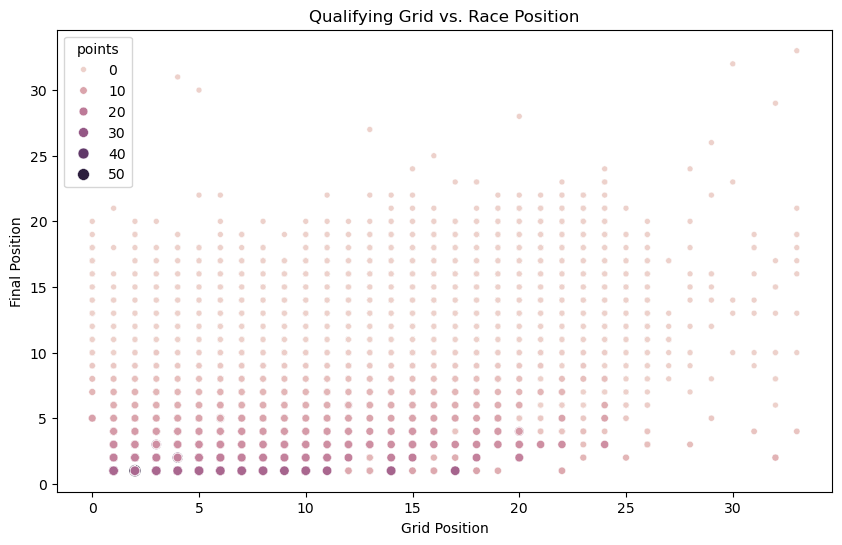

Correlation between Pit Stops and Finishing Position: 0.35


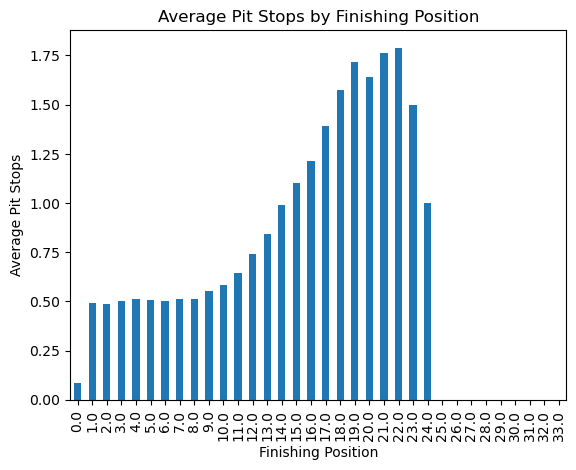

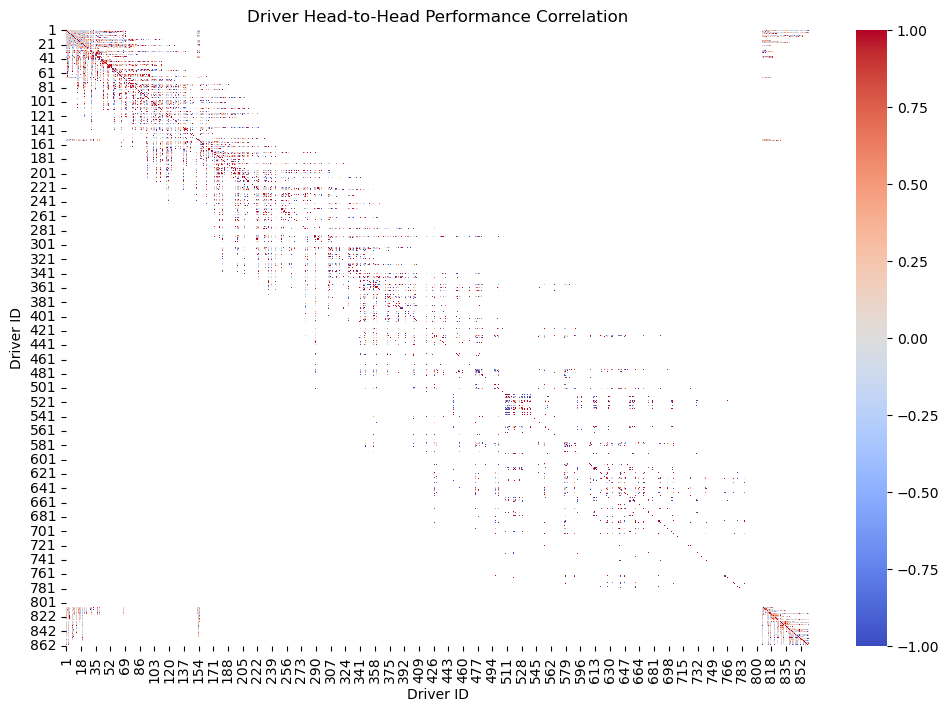


Top 5 Most Closely Matched Driver Pairs:
driverId  driverId
38        29          1.0
29        38          1.0
675       657         1.0
657       675         1.0
239       243         1.0
dtype: float64

Original Average Positions:
Driver 1: 3.63
Driver 13: 7.17

Simulated Average Positions after Swap:
Driver 1: nan
Driver 13: nan


C:\Users\SURYA\AppData\Local\Temp\ipykernel_13340\4184024752.py:180: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  driver_history = df.groupby('driverId').apply(lambda x: x[['constructorId', 'year']].sort_values('year'))


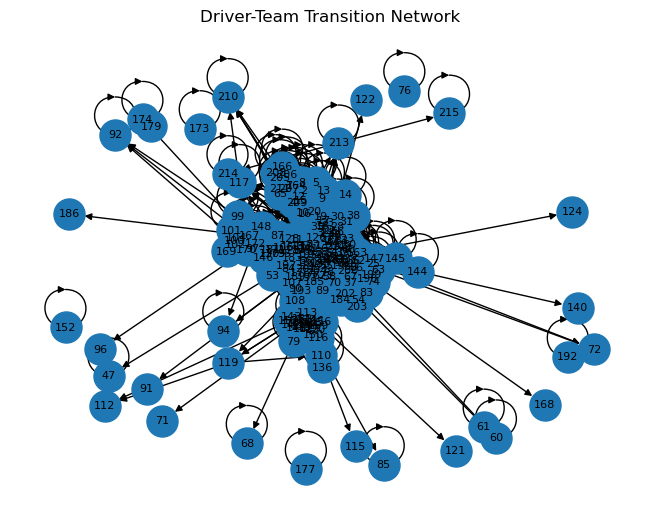

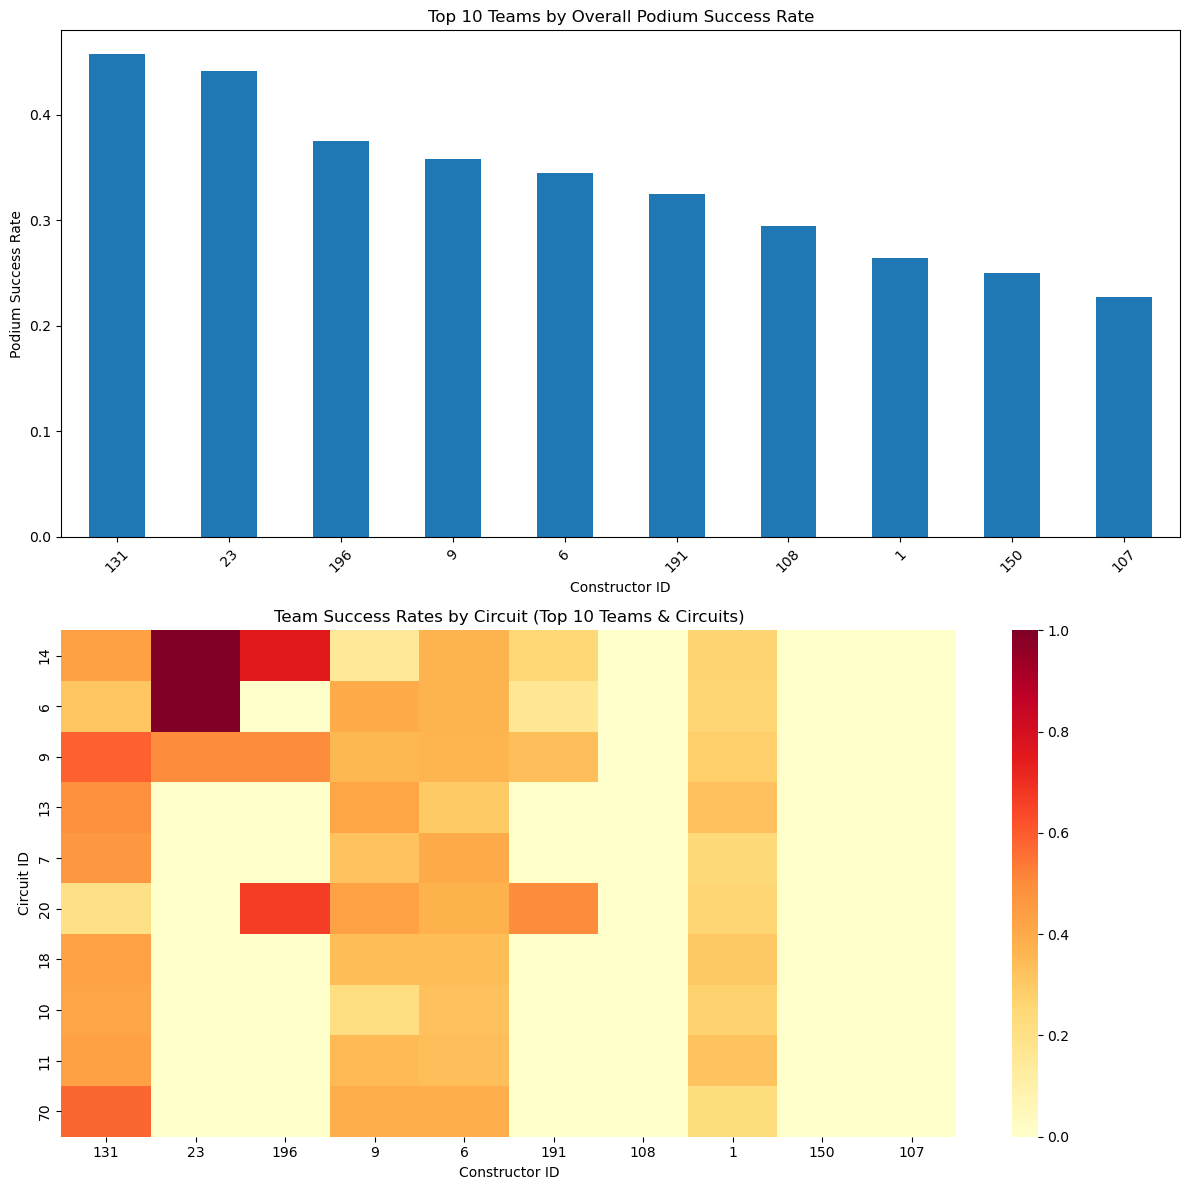


Overall Top 5 Teams by Success Rate:
constructorId
131    0.457055
23     0.441176
196    0.375000
9      0.357868
6      0.344813
dtype: float64

Circuit-Specific Success Rates (Sample):
constructorId
6      0.314961
131    0.234668
1      0.193383
9      0.187585
3      0.137390
dtype: float64
Most Consistent Top Performers:
     driverId  position_std  avg_position  top_10_ratio
641       642      1.569837      2.814815         72.97
632       633      1.673515      4.277778         51.43
646       647      1.967265      2.181818         61.11
497       498      1.972027      3.000000         65.52
553       554      2.158703      4.920000         43.86

Most Inconsistent Drivers:
     driverId  position_std  avg_position  top_10_ratio
8           9      5.499733      9.423529         52.53
845       847      5.432106      9.369369         49.22
9          10      5.316161     13.770270         22.11
820       822      5.302182      7.831818         58.70
36         37      5.17784

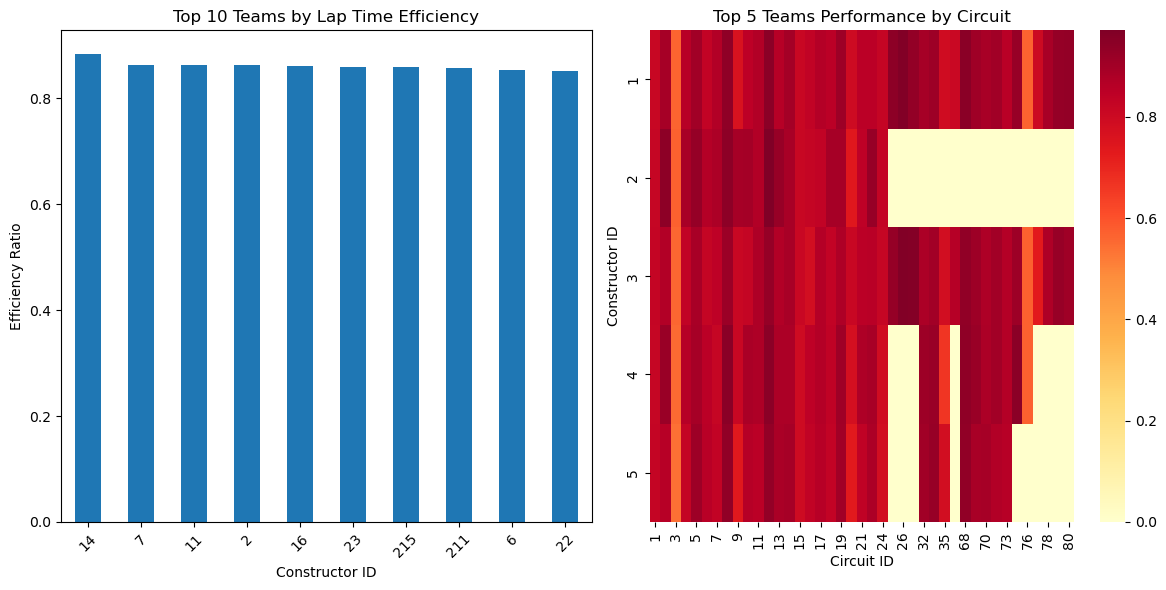


Top 5 Teams by Overall Efficiency:
constructorId
14    0.884218
7     0.863562
11    0.862999
2     0.862057
16    0.861117
Name: efficiency_ratio, dtype: float64

Top 5 Drivers by Lap Time Efficiency:
driverId
862    0.935144
861    0.909676
66     0.883574
31     0.883546
61     0.883448
Name: efficiency_ratio, dtype: float64

Best Team Lineup (Based on last 3 years):

Top 5 Drivers by Overall Performance:
 driverId  avg_points  podium_ratio  win_ratio  consistency_score  final_score
      830       19.45         0.778      0.589           0.500960     0.900192
        1       11.58         0.411      0.111           0.351248     0.428045
      844       10.69         0.344      0.067           0.410749     0.386012
      832        9.34         0.281      0.045           0.393474     0.332152
      815        9.77         0.322      0.056           0.138196     0.305573

Recommended Driver Pairing:
Driver 1 ID: 830.0 (Score: 0.900)
Driver 2 ID: 1.0 (Score: 0.428)

2025 Championship

C:\Users\SURYA\AppData\Local\Temp\ipykernel_13340\4184024752.py:459: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  yearly_points['point_growth'] = yearly_points.pct_change().mean()



Teams Most Likely to Struggle in 2025:
--------------------------------------------------

Constructor: alfa
Risk Score: 0.590
Average Points: 0.8
Position Consistency: 3.34
Development Trend: Positive

Constructor: alphatauri
Risk Score: 0.580
Average Points: 0.7
Position Consistency: 3.15
Development Trend: Positive

Constructor: alpine
Risk Score: 0.579
Average Points: 2.5
Position Consistency: 3.87
Development Trend: Positive

Driver Track Performance Analysis:
--------------------------------------------------

Worst Driver-Track Combinations:
      driverId  circuitId  avg_position  position_std  races
6280       538         19         17.33         13.05      3
649         24         22         17.00          5.20      3
403         15         24         15.33          7.37      3
632         24          5         16.67          4.73      3
392         15         12         14.75          7.41      4

Best Driver-Track Combinations:
      driverId  circuitId  avg_position  posi

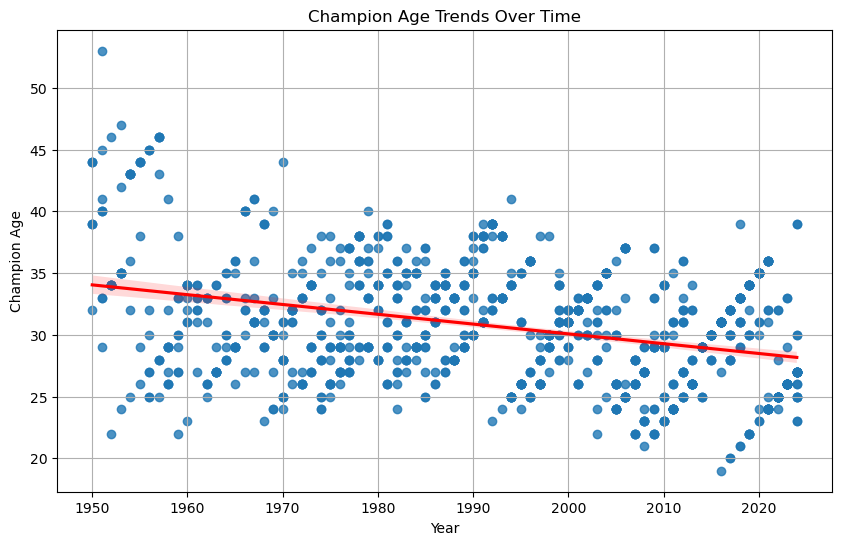


Age Statistics:
Average champion age: 30.7 years
Youngest champion: 19 years
Oldest champion: 53 years

Team History for hamilton:
Year 2007: mclaren (Avg Position: 3.0, Points: 109)
Year 2008: mclaren (Avg Position: 4.4, Points: 98)
Year 2009: mclaren (Avg Position: 7.6, Points: 49)
Year 2010: mclaren (Avg Position: 3.8, Points: 240)
Year 2011: mclaren (Avg Position: 3.8, Points: 227)
Year 2012: mclaren (Avg Position: 5.3, Points: 190)
Year 2013: mercedes (Avg Position: 5.2, Points: 189)
Year 2014: mercedes (Avg Position: 1.4, Points: 384)
Year 2015: mercedes (Avg Position: 1.7, Points: 381)
Year 2016: mercedes (Avg Position: 2.1, Points: 380)
Year 2017: mercedes (Avg Position: 2.7, Points: 363)
Year 2018: mercedes (Avg Position: 1.9, Points: 408)
Year 2019: mercedes (Avg Position: 2.4, Points: 413)
Year 2020: mercedes (Avg Position: 1.9, Points: 347)
Year 2021: mercedes (Avg Position: 2.8, Points: 386)
Year 2022: mercedes (Avg Position: 5.4, Points: 233)
Year 2023: mercedes (Avg Pos

In [132]:

def main():
    # Load primary dataset
    df = load_data("master_race_results.csv")
    
    # Run all analyses
    # driver_constructor_performance(df)
    # qualifying_vs_race_performance(df)
    # analyze_pit_stop_strategies(df)
    # head_to_head_analysis(df)
    # hypothetical_driver_swap(df, driver1="hamilton", driver2="massa")
    # driver_team_network(df)
    # team_performance_comparison(df)
    # driver_consistency(df)
    # lap_time_efficiency(df)
    # best_team_lineup(df)
    # predictions_2025(df)
    # struggling_teams(df)
    # driver_track_struggles(df)
    # championship_retention(df)
    # champion_age_trends(df)
    # predict_future_team("hamilton")

main()